### Importing needed packages

In [1]:
import math
import matplotlib.pyplot as plt

### Setting up parameters

In [20]:
#input parameters
S_0 = 100                                   #asset price at t=0
K = 99                                      #Strike price
optionType = "CALL"                         #Call or put option; "CALL" for call option, "PUT" for put option
optionKind = "EUR"                          #American or European option; "EUR" or "US"
r = .06                                     #yearly interest rate
T = 1                                       #total period in years
steps = 50                                  #amount of steps
dt = T / steps                              #step duration
vol = 0.2                                   #volatility


0.02


### Script to calculate European/American call/put option prices

In [12]:
#calculating step-by-step option value
def calculateOptionValue (fu, fd, u, d):
    p = (math.exp(r*dt) - d) / (u - d)
    fvalue = (p*fu + (1-p)*fd) * math.exp(-r*dt)
    return fvalue

#main function
def optionValuation (S_0, K, steps, optionKind, optionType, vol):
    
    #calculating volatility
    u = math.exp(vol * math.sqrt(dt))           #upward volatility
    d = math.exp(-(vol * math.sqrt(dt)))        #downward volatility

    #generate table with all associated asset prices
    table = []
    for i in range(0, steps+1):
        table.append([])
        for j in range(0, i+1):
            table[i].append(S_0 * (u ** (i-j)) * (d ** j) )
    table.reverse()

    #generate table with all associated option prices
    table_prices = []
    for i in range(len(table)):
        table_prices.append([])
        if i == 0:
            for j in range(len(table[i])):
                if optionType == "CALL":
                    table_prices[i].append(max(table[i][j]-K,0))
                elif optionType == "PUT":
                    table_prices[i].append(max(K-table[i][j],0))
        else:
            for j in range(len(table[i])):
                if optionKind == "EUR":
                    table_prices[i].append(calculateOptionValue (table_prices[i-1][j], table_prices[i-1][j+1], u, d))
                elif optionKind == "US":
                    if optionType == "CALL":
                        optionValue = calculateOptionValue (table_prices[i-1][j], table_prices[i-1][j+1], u, d)
                        payOff = table[i][j] - K
                        if payOff > optionValue:
                            table_prices[i].append(payOff)
                        else:
                            table_prices[i].append(optionValue)
                    elif optionType == "PUT":
                        optionValue = calculateOptionValue (table_prices[i-1][j], table_prices[i-1][j+1], u, d)
                        payOff =  K - table[i][j]
                        if payOff > optionValue:
                            table_prices[i].append(payOff)
                        else:
                            table_prices[i].append(optionValue)
                        
    return table_prices[-1][0]

In [13]:
optionValuation(S_0, K, steps, optionKind, optionType, 0.4) / optionValuation(S_0, K, steps, optionKind, optionType, 0.2)

1.6368767086762772

In [14]:
optionValuesVol = []
xvalues = []

                       
for i in range(50):
    optionValuesVol.append(optionValuation(S_0, K, steps, optionKind, optionType, (i+1)/100))
    xvalues.append(i)
print(optionValuesVol)

[6.7653111751591615, 6.765370752219661, 6.773564829292386, 6.824064900381636, 6.939838639622885, 7.112843391211868, 7.330178087285554, 7.580654607357224, 7.855900482353064, 8.149874356970908, 8.458224734572354, 8.777783768946163, 9.106210415815768, 9.441746494962045, 9.783050411398213, 10.129082872835783, 10.479027331848684, 10.832233794892014, 11.188178544803918, 11.546434850755071, 11.906651373040361, 12.26853603297133, 12.631843817153106, 12.996367450918159, 13.361930189752332, 13.728380192247963, 14.09558608679836, 14.463433448491738, 14.831821976632131, 15.200663216397928, 15.569878706655834, 15.939398464168546, 16.309159735319707, 16.67910596207209, 17.049185920626048, 17.41935300016673, 17.78956459591837, 18.1597815959927, 18.52996794560752, 18.900090275449024, 19.270117583467552, 19.640020961388675, 20.00977335880422, 20.379349378979608, 20.74872510153319, 21.117877927968525, 21.486786446713083, 21.855430314864517, 22.22379015429195, 22.591847460113826]


Text(0,0.5,'Bar')

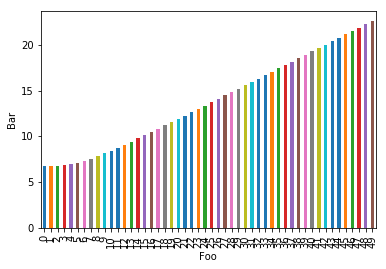

In [16]:

from matplotlib import pyplot as plt
import pandas as pd

s = pd.Series(optionValuesVol, xvalues)

s.plot.bar()
plt.xlabel('Foo')
plt.ylabel('Bar')